### Conditional density estimation with a block neural autoregressive flow

The model is as follows:
$$u_1 \sim \text{Uniform}(0,5)$$
$$u_2 \sim \text{Uniform}(0,5)$$

$$x_i \sim \text{Uniform}(0, u_i) \quad \text{for}\ i\ \text{in}\ \{1,2\}$$

We will try to infer the conditional distribution $p(x|u)$ using a conditional normalizing flow.


In [1]:
from jax import random
import jax.numpy as jnp
from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt

In [2]:
key, x_key, cond_key = random.split(random.PRNGKey(0), 3)
u = random.uniform(cond_key, (10000, 2), minval=0, maxval=5)
x = random.uniform(x_key, shape=u.shape, maxval=u)
assert jnp.all(x<u)

In [3]:
key, subkey = random.split(key)

flow = BlockNeuralAutoregressiveFlow(
    key=subkey,
    base_dist=Normal(x.shape[1]),
    cond_dim=u.shape[1])

key, subkey = random.split(key)
flow, losses = train_flow(subkey, flow, x, u, learning_rate=1e-2)

 70%|███████   | 35/50 [00:42<00:18,  1.21s/it, train=1.28, val=1.3] 

Max patience reached.


### Visualize learned conditional density
Let's condition on $u=[1,3]'$, in which case we expect $x_1 \sim \text{Uniform}(0, 1)$ and $x_2 \sim \text{Uniform}(0, 3)$

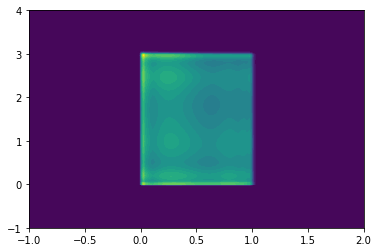

In [5]:
resolution = 200
u = jnp.array([1, 3])
xline = jnp.linspace(-1, 2, resolution)
yline = jnp.linspace(-1, 4, resolution)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.column_stack((xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)))
zgrid = jnp.exp(flow.log_prob(xyinput, u).reshape(resolution, resolution))

import numpy as onp
grids = [onp.array(g) for g in [xgrid, ygrid, zgrid]]
plt.contourf(*grids, levels=40)
plt.show()